In [32]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)

from preprocessor import AtomDataset
from randomizer import augment_data

torch.manual_seed(114514)

In [2]:
dataset = AtomDataset(root='./', threshold=2.0)
data = dataset._data
print(data)

Data(x=[220, 6], edge_index=[2, 544], y=[220, 1])


In [56]:
data.x

tensor([[  1.0000,   0.0000,   0.0000,  -3.2218, -12.4139,   0.0625],
        [  1.0000,   0.0000,   0.0000, -13.5626,   0.4588,  -1.5317],
        [  1.0000,   0.0000,   0.0000, -13.3524, -11.1130,  -0.2625],
        ...,
        [  0.0000,   0.0000,   1.0000,   9.4848, -11.2728,   1.1387],
        [  0.0000,   0.0000,   1.0000, -15.7903,  -7.6331,   0.6658],
        [  0.0000,   0.0000,   1.0000, -11.8829,  11.1650,   2.1042]])

In [3]:
augmented_dataset, original_ys = augment_data(data=data, num_new_data=50000, position_noise=0.05, moment_noise=1)

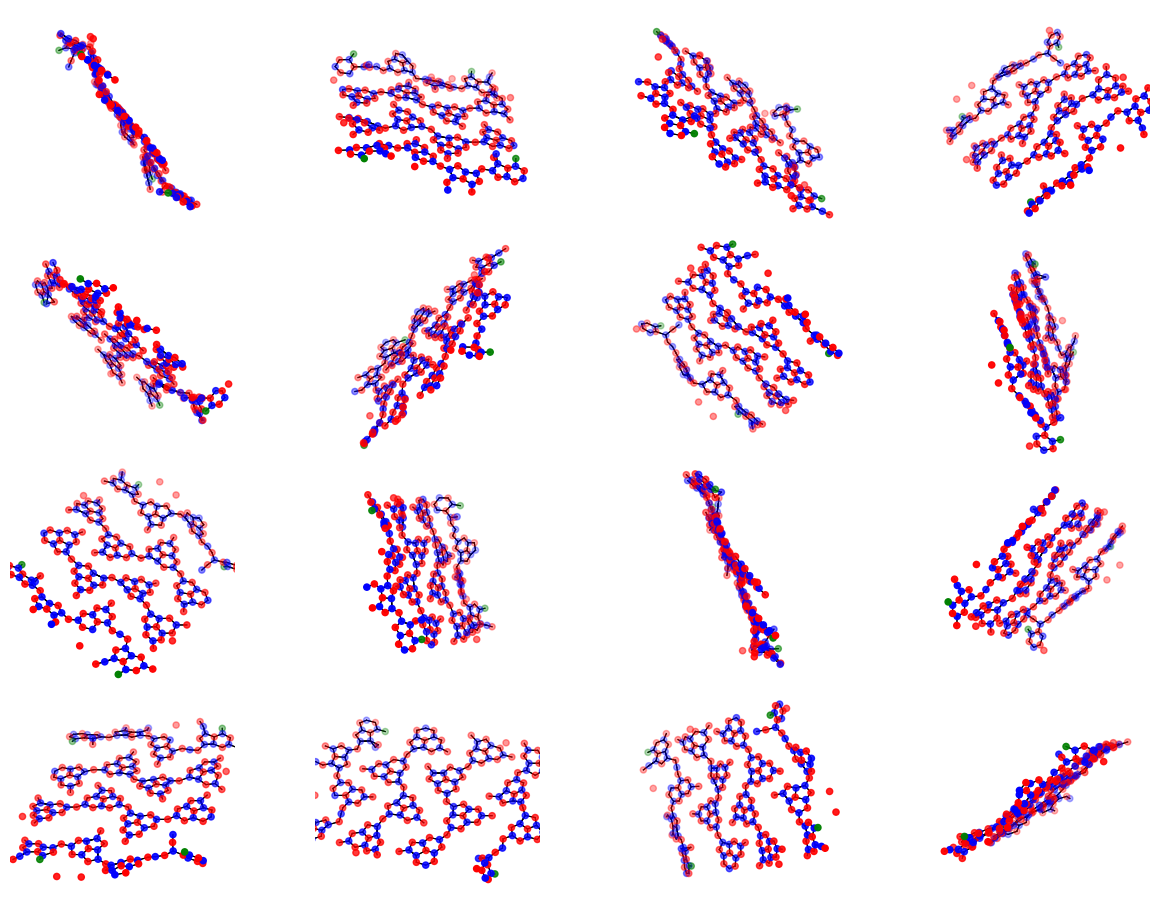

In [30]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14

atom2color = {
    0: 'red',   # nitrogen
    1: 'blue',  # carbon
    2: 'green'  # oxygen
}

fig = plt.figure(figsize=(15, 10))
nrows, ncols = 4, 4

for idx in range(nrows * ncols):  # Loop through the first 10 datasets
    coords = augmented_dataset[idx].x[:, -3:].numpy()
    bonds = augmented_dataset[idx].edge_index.numpy()
    
    # generate color of each atom
    atoms_one_hot = augmented_dataset[idx].x[:, :-3].numpy()
    atoms = np.argmax(atoms_one_hot, axis=1)
    colors = [atom2color[atom_type] for atom_type in atoms]

    ax = fig.add_subplot(nrows, ncols, idx + 1, projection='3d')  # Create a 5x2 grid subplot
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], color=colors, marker='o')  # Plot atoms

    # Plot bonds
    for i in range(bonds.shape[1]):
        start, end = bonds[:, i]
        x_coords = [coords[start, 0], coords[end, 0]]
        y_coords = [coords[start, 1], coords[end, 1]]
        z_coords = [coords[start, 2], coords[end, 2]]
        ax.plot(x_coords, y_coords, z_coords, c='k', linewidth=0.8)
        ax.set_xlim(-10, 10)
        ax.set_ylim(-10, 10)
        ax.set_zlim(-10, 10)
        ax.axis('off')

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=-0.3, hspace=0)
plt.show()

In [31]:
class GNNModel(nn.Module):
    def __init__(self, in_channels, g_hidden_channels, fc_hidden_channels, out_channels, dropout=0.0):
        super().__init__()
        self.conv1 = GCNConv(in_channels, g_hidden_channels)
        self.conv2 = GCNConv(g_hidden_channels, g_hidden_channels)
        self.conv3 = GCNConv(g_hidden_channels, g_hidden_channels)
        
        self.fc1 = Linear(g_hidden_channels, fc_hidden_channels)
        self.fc2 = Linear(fc_hidden_channels, fc_hidden_channels)
        self.fc3 = Linear(fc_hidden_channels, out_channels)

        self.dropout = dropout

    def forward(self, x, edge_index, batch=None):
        # x: (num_nodes, in_channels)
        # edge_index: (2, E)
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.fc1(x)
        x = torch.relu(x)

        x = self.fc2(x)
        x = torch.relu(x)

        x = self.fc3(x)
        
        return x
    
    def save_model(self, file_path: str = 'gnn_model.pt'):
        torch.save(self.state_dict(), file_path)
        print(f'Model saved to {file_path}.')

    @staticmethod
    def load_model(file_path: str,
                   in_channels: int,
                   g_hidden_channels: int,
                   fc_hidden_channels: int,
                   out_channels: int,
                   dropout=0.0):
        model = GNNModel(in_channels, g_hidden_channels, fc_hidden_channels, out_channels, dropout)
        model.load_state_dict(torch.load(file_path))
        print(f'Model loaded from {file_path}.')
        return model

In [22]:
import random

random.shuffle(augmented_dataset)

train_size = int(0.8 * len(augmented_dataset))
train_dataset = augmented_dataset[:train_size]
test_dataset = augmented_dataset[train_size:]

train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=True)

In [23]:
def compute_mse(pred, target):
    return F.mse_loss(pred, target)

def compute_r2(pred, target):
    """
    R^2 = 1 - [sum((y - y_pred)^2) / sum((y - mean(y))^2)]
    """
    # flatten to 1d
    pred = pred.view(-1)
    target = target.view(-1)

    ss_res = torch.sum((target - pred) ** 2)
    ss_tot = torch.sum((target - torch.mean(target)) ** 2)
    if ss_tot.item() == 0:
        # Edge case: if all target values are the same
        return torch.tensor(1.0) if ss_res.item == 0 else torch.tensor(0.0)
    
    r2 = 1 - ss_res / ss_tot
    return r2

class SignConstrainedMSELoss(torch.nn.Module):
    """
    A custom loss that applies MSE but heavily panalizes predictions with the wrong sign

    Args:
        penalty_factor (float): Multiplier (lambda) for sign mismatch
                                Loss = MSE(pred, y) + lambda * SignMismatchPenalty(pred, y)
    """
    def __init__(self, panelty_factor, soft_zone):
        super().__init__()
        self.panelty_factor = panelty_factor
        self.soft_zone = soft_zone

    def forward(self, y_pred, y_true):
        """
        y_pred, y_true: shape (N,) or (N, 1).
        Do a standard MSE plus the sign mismatch panelty if sign(y_pred) != sign(y_true)
        """
        # Flatten to (N,) if necessary
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)

        # compute base MSE
        mse_loss = F.mse_loss(y_pred, y_true)
        
        # sign mismatch panelty
        mismatch_neg = (y_true < -self.soft_zone) & (y_pred > 0)
        mismatch_pos = (y_true >  self.soft_zone) & (y_pred < 0)
        mismatch = mismatch_neg | mismatch_pos

        panelty = self._sign_mismatch_panelty(y_pred, mismatch)
        
        total_loss = mse_loss + torch.mean(panelty)
        return total_loss

    def _sign_mismatch_panelty(self, y_pred, mismatch):
        """
        panelty = panelty_factor * abs(y_pred)
        """
        panelty = torch.zeros_like(y_pred)
        panelty[mismatch] = self.panelty_factor * torch.abs(y_pred[mismatch])
        return panelty

In [35]:
device = torch.device('cuda:0')
epochs = 100

model = GNNModel(
    in_channels=6,
    g_hidden_channels=64,
    fc_hidden_channels=64,
    out_channels=1,
    dropout=0.05
)
sign_constrained_mse = SignConstrainedMSELoss(panelty_factor=5, soft_zone=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
model = model.to(device)

print(model)
print(sum(p.numel() for p in model.parameters()))

GNNModel(
  (conv1): GCNConv(6, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)
17153


In [36]:
avg_train_losses = []
avg_test_losses = []

for epoch in range(1, epochs + 1):
    # Train
    model.train()
    train_losses = []
    for batch_data in train_loader:
        batch_data = batch_data.to(device)
        optimizer.zero_grad()

        out = model(batch_data.x, batch_data.edge_index, batch_data.batch)
        # flatten to (num_nodes,) if out has shape (num_nodes, 1)
        if out.shape[-1] == 1:
            out = out.view(-1)
        y = batch_data.y.view(-1)

        train_loss = sign_constrained_mse(out, y)
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())
    
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    test_losses = []
    test_r2_scores = []
    with torch.no_grad():
        for batch_data in test_loader:
            batch_data = batch_data.to(device)
            out = model(batch_data.x, batch_data.edge_index, batch_data.batch)
            if out.shape[-1] == 1:
                out = out.view(-1)
            y = batch_data.y.view(-1)

            test_loss = sign_constrained_mse(out, y)
            r2 = compute_r2(out, y)

            test_losses.append(test_loss.item())
            test_r2_scores.append(r2.item())

    scheduler.step(test_loss)
    current_lr = optimizer.param_groups[0]['lr']

    avg_test_loss = sum(test_losses) / len(test_losses)
    avg_test_r2 = sum(test_r2_scores) / len(test_r2_scores)
    avg_test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch}/{epochs}] "
          f"Train MSE: {avg_train_loss:.4f} | "
          f"Test MSE: {avg_test_loss:.4f}, Test R^2: {avg_test_r2:.4f} | "
          f"LR: {current_lr:.6f}")


Epoch [1/100] Train MSE: 4.3322 | Test MSE: 4.2702, Test R^2: 0.0027 | LR: 0.010000
Epoch [2/100] Train MSE: 4.2672 | Test MSE: 4.2661, Test R^2: 0.0032 | LR: 0.010000
Epoch [3/100] Train MSE: 4.2617 | Test MSE: 4.2562, Test R^2: 0.0067 | LR: 0.010000
Epoch [4/100] Train MSE: 4.2518 | Test MSE: 4.2365, Test R^2: 0.0104 | LR: 0.010000
Epoch [5/100] Train MSE: 4.2292 | Test MSE: 4.2165, Test R^2: 0.0149 | LR: 0.010000
Epoch [6/100] Train MSE: 4.2166 | Test MSE: 4.2103, Test R^2: 0.0162 | LR: 0.010000
Epoch [7/100] Train MSE: 4.2111 | Test MSE: 4.2008, Test R^2: 0.0286 | LR: 0.010000
Epoch [8/100] Train MSE: 4.2008 | Test MSE: 4.1923, Test R^2: 0.0361 | LR: 0.010000
Epoch [9/100] Train MSE: 4.1702 | Test MSE: 4.1126, Test R^2: 0.0614 | LR: 0.010000
Epoch [10/100] Train MSE: 4.0992 | Test MSE: 4.0158, Test R^2: 0.0756 | LR: 0.010000
Epoch [11/100] Train MSE: 3.9878 | Test MSE: 3.8493, Test R^2: 0.1095 | LR: 0.010000
Epoch [12/100] Train MSE: 3.8887 | Test MSE: 3.7400, Test R^2: 0.1303 | LR

In [37]:
model.save_model()

Model saved to gnn_model.pt.


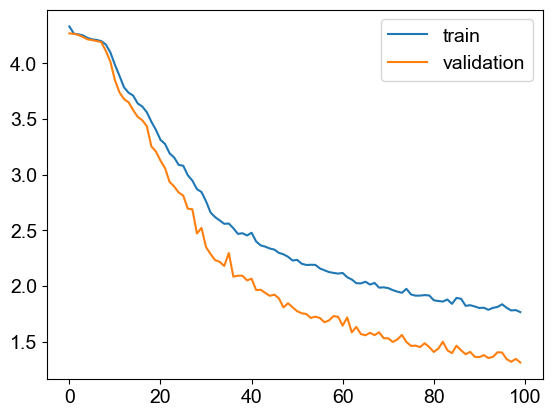

In [53]:
plt.plot(avg_train_losses, label='train')
plt.plot(avg_test_losses, label='validation')

plt.legend()

In [46]:
model = GNNModel.load_model('gnn_model.pt',
                             in_channels=6,
                             g_hidden_channels=64,
                             fc_hidden_channels=64,
                             out_channels=1,
                             dropout=0.05)

model.eval()
model.to(device)

all_preds = []
all_truth = []

with torch.no_grad():
    for batch_data in train_loader:
        batch_data = batch_data.to(device)

        out = model(batch_data.x, batch_data.edge_index, batch_data.batch)

        out_flat = out.view(-1).cpu().numpy()
        y_flat = batch_data.y.view(-1).cpu().numpy()

        all_preds.append(out_flat)
        all_truth.append(y_flat)

predictions = np.concatenate(all_preds, axis=0)
ground_truth = np.concatenate(all_truth, axis=0)

C:\Users\y1hli\AppData\Local\Temp\ipykernel_83404\4052518928.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path))


Model loaded from gnn_model.pt.


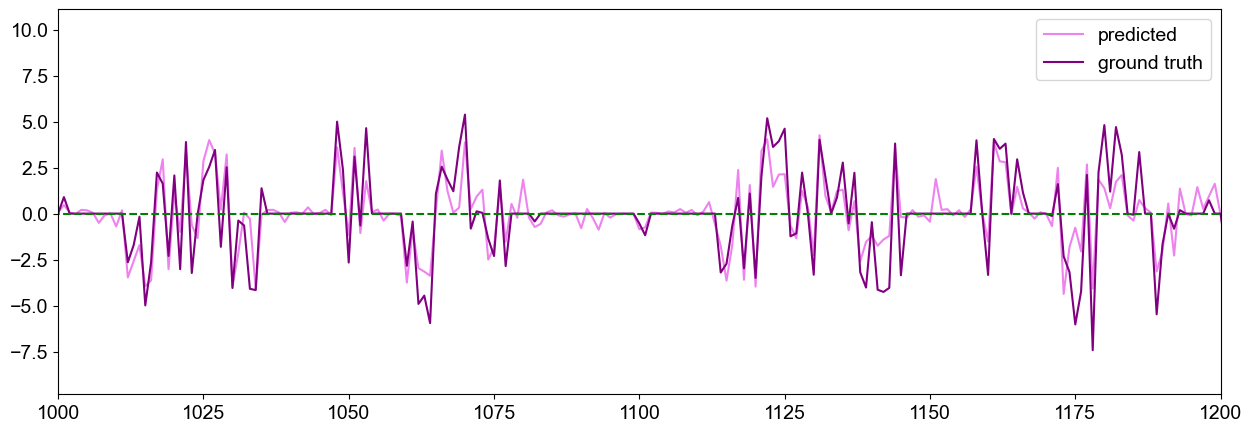

In [50]:
plt.figure(figsize=(15, 5))

plt.plot(predictions, c='violet', label='predicted')
plt.plot(ground_truth, c='purple', label='ground truth')
plt.plot(np.zeros_like(predictions), ls='--', c='g')

plt.xlim(1000, 1200)

plt.legend()

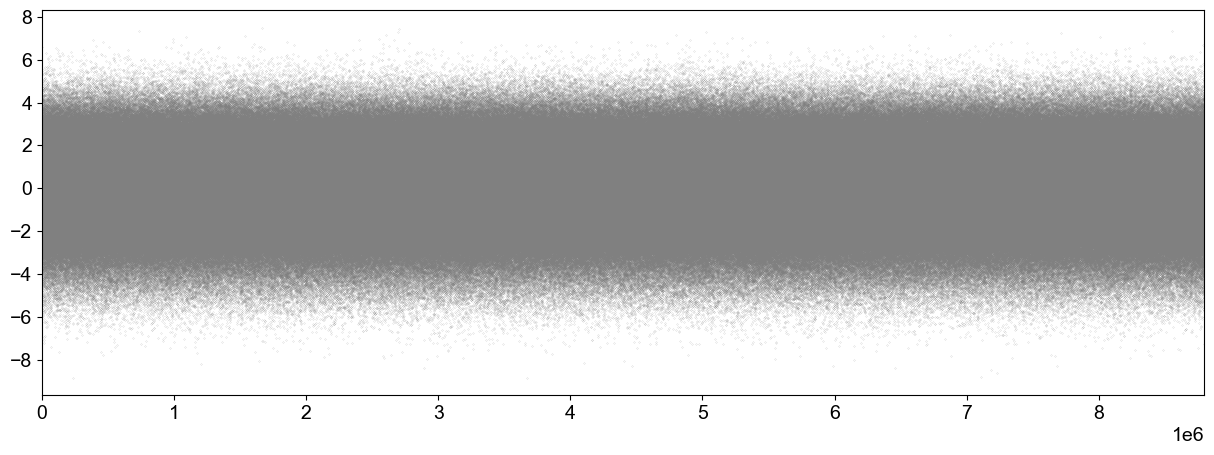

In [55]:
plt.figure(figsize=(15, 5))
plt.plot(ground_truth - predictions, 'o', c='gray', ms=0.1)
plt.xlim(0, len(ground_truth))
plt.show()

[]

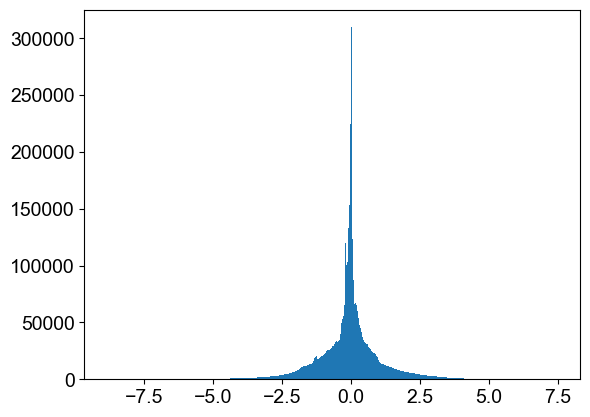

In [52]:
plt.hist(ground_truth - predictions, bins=1000)
plt.plot()